# Task3: One pixel in-painting
In this part we need to get the most likely image given both past and futre pixels. In order to do this, all possible outcomes(pixel predictions) are compared and the outcomes of the lowest cost are chossen. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import pdb
import matplotlib.image as mpimg
import matplotlib.cm as cm
from itertools import chain
import random

In [2]:
# Need to load the MNist data to work with
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/MNIST/", one_hot=True)
# one hot true gives the y labels as vectors with 1's which correspond to the number it is

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


Load the data.

In [3]:
one_pixel_inpainting =np.load('one_pixel_inpainting.npy')
one_pixel_inpainting1 =np.load('one_pixel_inpainting.npy')

Create the ground truth and the images with 0 and 1 as the missing pixel

In [4]:
# Real hacky way of doing it but even when I was slicing, it would still overwrite.
pic_mask0 = one_pixel_inpainting[0,:,:]
pic_mask1 = one_pixel_inpainting1[0,:,:]

pic_GT = one_pixel_inpainting[1,:,:]
np.where(pic_mask0==--1)

(array([  0,   0,   0, ..., 999, 999, 999], dtype=int64),
 array([125, 126, 127, ..., 685, 686, 687], dtype=int64))

In [5]:
np.where(pic_mask0==-1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

Find the missing pixels indices

In [6]:
diff = pic_mask0 - pic_GT
indexes =(diff).nonzero()
miss_pix_ind =indexes[1] # missng pixel indeces


In [7]:
# Replace the -1 in the images with either ones or zeros
pixel_one = pic_mask1.copy()
pixel_zero = pic_mask0.copy()

for i in range(len(miss_pix_ind)):
    pixel_zero[i,miss_pix_ind[i]] =0
    
    pixel_one[i,miss_pix_ind[i]] = 1
    

In [8]:
def RNN_predict(input_pixels,gt_pixels,rnn_size):


    probs = []

    # GRU layer
    gru_cell = tf.nn.rnn_cell.GRUCell(num_units=rnn_size)
    outputs, state = tf.nn.dynamic_rnn(cell=gru_cell, dtype=tf.float32, inputs=input_pixels)
    # Shape outputs so its batch size=100*484, rnn_size=32
    outputs = tf.reshape(outputs, [-1, rnn_size])
    
    # affine transformation
    outputs = tf.matmul(outputs, weights) + biases
    
    # Reshape so that (batch size,pix_len)
    sampled = tf.reshape(input_pixels,[-1, 784])
    gt = tf.reshape(gt_pixels,[-1, 784])
    logits = tf.reshape((outputs), [-1, 784])
    # Calculate the cost between the ground truth image and the probs(outcomes)
    cost_gt = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(targets=gt[:,1:], logits=logits[:,:-1]), axis = 1)
    
    # Calculate the cost between the image you sampled and the probs(outcomes)
    cost_sampled = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(targets=sampled[:,1:], logits=logits[:,:-1]), axis = 1)
    
    outputs = tf.reshape(tf.nn.sigmoid(outputs), [-1, 784])
    return cost_sampled,cost_gt, outputs, logits
   

In [9]:
def binarize(images, threshold=0.1):
    return (threshold < images).astype('float32')

Set up the placeholders, variables and parameters

In [10]:
n_classes = 10
batch_size = 100
chunk_size = 1
n_chunks = 784
rnn_size = 128
first_pix = 484
#seq_len = 10
#
#full = first_pix+seq_len
sampled_seq_list =[]
cost_list=[]
cost_values = []
n_samples = 10
random.seed(10)
seq_len = miss_pix_ind

# Define the placeholders that will be used
x = tf.placeholder('float', [None, n_chunks,chunk_size])
y = tf.placeholder('float', [None, n_chunks,chunk_size])

# Taking the first 484 pixels of the fitst 100 images
x_in_paint = x[:,0:first_pix,:]

logs_path = '/tmp/tensorflow_logs/example'

In [11]:
weights = tf.Variable(tf.random_normal([rnn_size, 1]))
biases =  tf.Variable(tf.random_normal([1]))

In [12]:
# Set up the graph
cost_sampled, cost_gt,probs, logits = RNN_predict(x,y,rnn_size)

In [13]:
init = tf.global_variables_initializer()
with tf.Session() as sess:    
    sess.run(init)
    save_MDir = 'models/Task2/gru128/'
    save_model = os.path.join(save_MDir,'best_accuracy_3')
    saver2restore = tf.train.Saver()
    saver2restore.restore(sess = sess, save_path= save_model)
    start = time.time()
    
    # Compute the costs and probs for the images with 0 as the missing pixel
    batch_x = pixel_zero
    batch_x = binarize(batch_x)
    batch_x = batch_x.reshape(1000,784,chunk_size)
    
    
    # main work done here
    cost_s0,cost_gt0,pix_probs0,logits0 = sess.run([cost_sampled,cost_gt,probs,logits],feed_dict={x:batch_x, y:pic_GT.reshape(1000,784,chunk_size)})
    
    # Compute the costs and probs for the images with 1 as the missing pixel
    batch_y = pixel_one
    batch_y = binarize(batch_y)
    batch_y = batch_y.reshape(1000,784,chunk_size)
    #batch_y = mnist.test.labels[:batch_size]
    
    # main work done here
    cost_s1,cost_gt1,pix_probs1, logits1 = sess.run([cost_sampled,cost_gt,probs,logits],feed_dict={x:batch_y, y:pic_GT.reshape(1000,784,chunk_size)})
   

In [14]:
# Stack the cost toger to compare
compare=np.stack((cost_s0, cost_s1),axis =1).reshape(1000,2)

In [15]:
# Since took the negative, look at max, not min
predictions = np.argmax(compare, axis = 1)
accuracy = 0

# compare the predicted indices to the actual missing 
for i  in range(1000):
    if pic_GT[i, miss_pix_ind[i]]== predictions[i]:
         accuracy+=1
print(accuracy/1000)    

0.95


In [16]:
ml_Xent = 0
gt_Xent =0
pred_image = []
accuracy = 0
count =0
count2 = 0
mistake_list=[]
# loop over each image check if correct and sum up the sample cost and ml cost.
for i in range(1000):
    if predictions[i]==0:
        ml_Xent += -cost_s0[i]
        gt_Xent += -cost_gt0[i]
        pred_image.append(pixel_zero[i,:])
        accuracy += (0 == pic_GT[i, miss_pix_ind[i]])
        count +=1
        if 0 != pic_GT[i, miss_pix_ind[i]]:
            mistake_list.append(i)
    else:
        ml_Xent += -cost_s1[i]
        gt_Xent += -cost_gt1[i]
        pred_image.append(pixel_one[i,:])
        accuracy += (1 == pic_GT[i, miss_pix_ind[i]])
        count +=1
        if 1 != pic_GT[i, miss_pix_ind[i]]:
            mistake_list.append(i)        

In [17]:
print('The maximum likelihood average loss is: {:.6}'.format(ml_Xent/1000))
print('The ground truth average loss is: {:.6}'.format(gt_Xent/1000))
print('The number of correctly predicted pixels is : {:.1%}'.format(accuracy/1000))

The maximum likelihood average loss is: 61.6105
The ground truth average loss is: 61.6393
The number of correctly predicted pixels is : 95.0%


### Saving the images

In [18]:
submit_images = np.asarray(pred_image)
submit_images =submit_images.reshape(1,1000,784)


In [19]:
new_inpaintings = np.append(one_pixel_inpainting,submit_images,axis = 0)

In [20]:
#np.save('one_pixel_inpainting_submit.npy', new_inpaintings)

In [21]:
#reloaded_model =  np.load('one_pixel_inpainting_submit.npy')

In [22]:
#np.save('one_pixel_inpainting.npy', new_inpaintings)

In [23]:
reloaded_model =  np.load('one_pixel_inpainting.npy')

In [24]:
reloaded_model.shape

(3, 1000, 784)

Sample of correct predictions

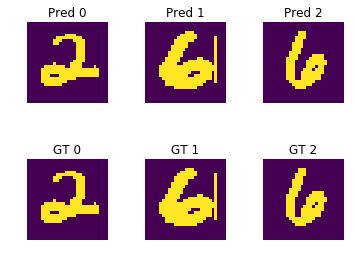

In [25]:
my_images = reloaded_model[2,:,:]
gt_images = reloaded_model[1,:,:]
masked_images = reloaded_model[0,:,:]
f2, axar = plt.subplots(2, 3)

#correct images
for i in range(3):
    axar[0, i].imshow(my_images[i,:].reshape(28,28))
    axar[0, i].set_title('Pred {}'.format(i))
    axar[0, i].axis('off')

    axar[1, i].imshow(gt_images[i,:].reshape(28,28))
    axar[1, i].set_title('GT {}'.format(i))
    axar[1, i].axis('off')
    
f2.subplots_adjust(hspace=0.7)
#plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/1pix_good.png', dpi =150)
plt.show()

Sample of incorrect predctions

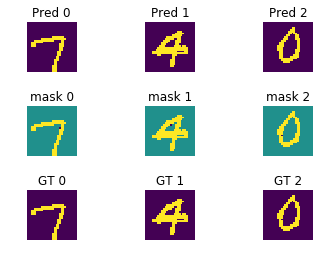

In [26]:
f2, axar = plt.subplots(3, 3)
#mistakes
for i in range(3):
    axar[0, i].imshow(my_images[mistake_list[i],:].reshape(28,28))
    axar[0, i].set_title('Pred {}'.format(i))
    axar[0, i].axis('off')
    
    axar[1, i].imshow(masked_images[mistake_list[i],:].reshape(28,28))
    axar[1, i].set_title('mask {}'.format(i))
    axar[1, i].axis('off')    
    
    
    axar[2, i].imshow(gt_images[mistake_list[i],:].reshape(28,28))
    axar[2, i].set_title('GT {}'.format(i))
    axar[2, i].axis('off')
    
f2.subplots_adjust(hspace=0.7)
#plt.savefig('C:/Users/Alex/.ipython/CW2/models/Task2/images/1pix_mistake.png', dpi =150)
plt.show()